# Figure 7: Classifying TFs into Neg. Regs. vs. Rewirers

- classification based on assay results

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import statsmodels.stats.multitest as smt
from upsetplot import plot

# import utils
sys.path.append("../")
sys.path.append("../data_loading")

import plotting
from plotting import PAPER_PRESET, PAPER_FONTSIZE, nice_boxplot, mimic_r_boxplot, annotate_pval

from data_loading import (load_annotated_TFiso1_collection,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped,
                          load_ref_vs_alt_isoforms_table,
                          load_condensate_data)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## functions

In [5]:
def calculate_tau(df):
    array = df.values
    
    ## will return NaN as tau for every row that has any NaNs
    array_max = np.max(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nonan_taus = np.sum(tmp, axis=1) / (array.shape[1])
    
    ## will ignore NaNs and compute on the rest of the values
    array_max = np.nanmax(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nan_taus = np.nansum(tmp, axis=1) / np.count_nonzero(~np.isnan(array), axis=1)
    
    
    return nonan_taus, nan_taus, array_max

In [6]:
rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

In [7]:
dn_pal = {"ref": sns.color_palette("Set2")[0],
       "similar": sns.color_palette("Set2")[0],
       "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1],
       "NA": "lightgray",
       "likely": "darkgray",
          "combination": sns.color_palette("Set2")[5],
          "assessed": sns.color_palette("Set2")[5]}

## variables

In [8]:
joung_orf_f = "../../data/external/joung_files/Joung_ORF_lib.txt"
joung_data_f = "../../data/external/joung_files/Joung_ORF_scores.txt"
joung_cells_f = "../../data/external/joung_files/Figure3B_celltype_mapping.csv"

joung_down_map_batch_f = "../../data/external/joung_files/subsample_mapping_batch.txt"
joung_down_map_TF_f = "../../data/external/joung_files/subsample_mapping_TF.txt"
joung_down_map_louvain_f = "../../data/external/joung_files/subsample_mapping_louvain.txt"

## 1. import data

In [9]:
pairs = load_ref_vs_alt_isoforms_table()

# RORC-1 alt iso is causing an error - filter out here - there's no data for it?
pairs = pairs[pairs["clone_acc_alt"] != "RORC|1/6|05F11"]

pairs['ref_iso'] = pairs['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['alt_iso'] = pairs['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [10]:
len(pairs[pd.isnull(pairs["dbd_pct_lost"])])

30

In [11]:
pairs[pairs['alt_iso'] == 'TBX5-2'].iloc[0]

gene_symbol                                                                         TBX5
Ensembl_gene_ID                                                          ENSG00000089225
family                                                                             T-box
is_dimerizing_TF_family                                                            False
clone_acc_ref                                                             TBX5|1/3|08E01
clone_acc_alt                                                             TBX5|2/3|08C02
Ensembl_transcript_IDs_ref                               ENST00000310346|ENST00000405440
Ensembl_transcript_IDs_alt                                               ENST00000349716
is_ref_novel_isoform                                                               False
is_alt_novel_isoform                                                               False
is_MANE_select_isoform_cloned                                                       True
n_aa_ref             

In [12]:
joung_orf = pd.read_table(joung_orf_f)
joung_orf["Name"] = joung_orf["Name"].str.strip()

joung_data = pd.read_table(joung_data_f)
joung_data["Name"] = joung_data["TF ORF"].str.split("-", expand=True)[0].str.strip()

joung_cells = pd.read_table(joung_cells_f, sep=",")

joung_down_map_batch = pd.read_table(joung_down_map_batch_f, index_col=0)
print(len(joung_down_map_batch))
joung_down_map_TF = pd.read_table(joung_down_map_TF_f, index_col=0)
print(len(joung_down_map_TF))
joung_down_map_louvain = pd.read_table(joung_down_map_louvain_f, index_col=0)
print(len(joung_down_map_louvain))

joung_down_map = joung_down_map_batch.join(joung_down_map_TF).join(joung_down_map_louvain)
print(len(joung_down_map))

671453
671453
671453
671453


In [13]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [14]:
metadata_gtex_dummy = pd.read_table("../../data/processed/metadata_gtex_dummy.csv", sep=",", index_col=0)

In [15]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


## 2. categorize based on assay data

### M1H

In [16]:
def m1h_cat(row):
    
    # ref is activator
    if row.activation_ref >= 1:
        if row.activation_fold_change_log2 <= -1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "activation loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            
            # only consider iso to be rewired if foldchange > 2x
            if np.abs(row.activation_fold_change_log2) >= 1:
                return "rewire"
            else:
                return "similar"

        else:
            return "NA"
    
    # ref is repressor
    elif row.activation_ref <= -1:
        if row.activation_fold_change_log2 >= 1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "repression loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            
            # only consider iso to be rewired if foldchange > 2x
            if np.abs(row.activation_fold_change_log2) >= 1:
                return "rewire"
            else:
                return "similar"
        else:
            return "NA"
        
    # no ref data so can't make conclusions
    elif pd.isnull(row.activation_ref):
        return "NA"
    
    # ref is middling so can be GoF
    else:
        if row.activation_fold_change_log2 >= 1:
            return "activation GoF"
        elif row.activation_fold_change_log2 <= -1:
            return "repression GoF"
        
        # if both isoforms are middling, consider similar
        elif not pd.isnull(row.activation_fold_change_log2):
            return "similar"
        
        else:
            return "NA"
        
pairs["m1h_cat"] = pairs.apply(m1h_cat, axis=1)
pairs.m1h_cat.value_counts()

m1h_cat
similar            194
NA                 120
rewire              61
activation loss     39
repression GoF      16
activation GoF       9
repression loss      8
Name: count, dtype: int64

### Y1H

In [17]:
def y1h_cat(row):
    if row.n_positive_PDI_ref_filtered > 0:
        if row.n_positive_PDI_alt_filtered == 0:
            return "PDI loss"
        elif row.n_shared_PDI == row.n_PDI_successfully_tested_in_ref_and_alt:
            return "no PDI change"
        elif pd.isnull(row.n_positive_PDI_alt_filtered):
            return "NA"
        else:
            return "PDI rewire"
    elif row.n_positive_PDI_ref_filtered == 0:
        if row.n_positive_PDI_alt_filtered > 0:
            return "PDI gain"
        else:
            return "NA"
    else:
        return "NA"
    
pairs["y1h_cat"] = pairs.apply(y1h_cat, axis=1)
pairs.y1h_cat.value_counts()

y1h_cat
NA               377
PDI loss          26
PDI rewire        22
no PDI change     13
PDI gain           9
Name: count, dtype: int64

### Y2H

In [18]:
def y2h_cat(row):
    if row.dimer_ppi == "loses all" or row.tf_cofactor_ppi == "loses all" or row.tf_signalling_ppi == "loses all":
        n = []
        if row.dimer_ppi == "loses all":
            n.append("dimer")
        if row.tf_cofactor_ppi == "loses all":
            n.append("cofactor")
        if row.tf_signalling_ppi == "loses all":
            n.append("signalling")
        s = ",".join(n)
        s = "PPI loss: %s" % s
        return s
    
    elif row.n_positive_PPI_ref > 0 and row.n_positive_PPI_alt == 0:
        return "PPI loss: all"
    
    elif row.dimer_ppi == "retains all" and row.tf_cofactor_ppi == "retains all" and row.tf_signalling_ppi == "retains all":
        if row.other_than_dimer_ppi == "retains all":
            return "no PPI change (all PPIs)"
        else:
            return "no PPI change (important PPIs)"
    
    elif pd.isnull(row.dimer_ppi) and pd.isnull(row.tf_cofactor_ppi) and pd.isnull(row.tf_signalling_ppi) and pd.isnull(row.other_than_dimer_ppi) and pd.isnull(row.tf_tf_ppi):
        return "NA"
    
    else:
        
        # all PPIs retained but some above categories null so missed in if statements
        if row.PPI_jaccard == 1:
            return "no PPI change (all PPIs)"
        else:
            return "PPI rewire"
    
pairs["y2h_cat"] = pairs.apply(y2h_cat, axis=1)
pairs.y2h_cat.value_counts()

y2h_cat
NA                                295
PPI loss: all                      52
PPI rewire                         47
no PPI change (all PPIs)           25
PPI loss: signalling                8
PPI loss: cofactor,signalling       8
PPI loss: cofactor                  5
no PPI change (important PPIs)      4
PPI loss: dimer                     3
Name: count, dtype: int64

## localization

In [19]:
con_pairs, con_df = load_condensate_data()

In [20]:
pairs = pairs.merge(con_pairs[["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                               'condensates_observed_HEK_ref',
       'condensates_observed_U2OS_ref', 'HEK_Condensate_ref',
       'U2OS_Condensate_ref', 'localization_HEK_ref', 'localization_U2OS_ref',
       'condensates_observed_HEK_alt', 'condensates_observed_U2OS_alt',
       'HEK_Condensate_alt', 'U2OS_Condensate_alt', 'localization_HEK_alt',
       'localization_U2OS_alt', 'condensate_cat_HEK', 'condensate_cat_U2OS',
       'condensate_cat_merged_HEK', 'condensate_cat_merged_U2OS',
       'condensate_cat_only_HEK', 'condensate_cat_only_U2OS',
       'localization_cat_HEK', 'localization_cat_U2OS',
       'condensate_cat_only_detailed_HEK', 'condensate_cat_only_detailed_U2OS',
       'condensate_or_loc_change_HEK', 'condensate_or_loc_change_U2OS',
       'combined_cat_HEK', 'combined_cat_U2OS',
       'condensate_or_loc_change_both', 'condensate_cat_detailed_HEK',
       'condensate_cat_detailed_U2OS']], how="left", on=["gene_symbol", "clone_acc_ref", "clone_acc_alt"])

In [21]:
pairs.localization_HEK_ref.value_counts()

localization_HEK_ref
both         70
nucleus      52
cytoplasm     7
Name: count, dtype: int64

In [22]:
def loc_cat_HEK(row):
    if row.localization_HEK_ref == "nucleus" or row.localization_HEK_ref == "both":
        if row.localization_HEK_alt == "cytoplasm":
            return "localization loss"
        elif row.localization_HEK_alt == "nucleus" or row.localization_HEK_alt == "both":
            return "no localization change"
        elif not pd.isnull(row.localization_HEK_alt):
            return "localization change"
        else:
            return "NA"
        
    # if ref is exclusively cytoplasm, call loc change but not loc loss
    elif row.localization_HEK_ref == "cytoplasm":
        if row.localization_HEK_alt == "cytoplasm":
            return "no localization change"
        elif row.localization_HEK_alt == "nucleus" or row.localization_HEK_alt == "both":
            return "localization change"
        elif not pd.isnull(row.localization_HEK_alt):
            return "localization change"
        else:
            return "NA"
    
    else:
        return "NA"
    
def loc_cat_U2OS(row):
    if row.localization_U2OS_ref == "nucleus" or row.localization_U2OS_ref == "both":
        if row.localization_U2OS_alt == "cytoplasm":
            return "localization loss"
        elif row.localization_U2OS_alt == "nucleus" or row.localization_U2OS_alt == "both":
            return "no localization change"
        elif not pd.isnull(row.localization_U2OS_alt):
            return "localization change"
        else:
            return "NA"
        
    # if ref is exclusively cytoplasm, call loc change but not loc loss
    elif row.localization_U2OS_ref == "cytoplasm":
        if row.localization_U2OS_alt == "cytoplasm":
            return "no localization change"
        elif row.localization_U2OS_alt == "nucleus" or row.localization_U2OS_alt == "both":
            return "localization change"
        elif not pd.isnull(row.localization_U2OS_alt):
            return "localization change"
        else:
            return "NA"
    
    else:
        return "NA"
        
def loc_cat(row):
    if row.loc_cat_HEK == "localization loss" or row.loc_cat_U2OS == "localization loss":
        return "localization loss"
    elif row.loc_cat_HEK == "localization change" or row.loc_cat_U2OS == "localization change":
        return "localization change"
    elif row.loc_cat_HEK == "no localization change" and row.loc_cat_U2OS == "no localization change":
        return "no localization change"
    else:
        return "NA"
    
pairs["loc_cat_HEK"] = pairs.apply(loc_cat_HEK, axis=1)
pairs["loc_cat_U2OS"] = pairs.apply(loc_cat_U2OS, axis=1)
pairs["loc_cat"] = pairs.apply(loc_cat, axis=1)
pairs.loc_cat.value_counts()

loc_cat
NA                        321
no localization change    109
localization loss          15
localization change         2
Name: count, dtype: int64

In [23]:
len(pairs[pairs["loc_cat"] != "NA"])

126

## 3. categorize negative regulators
include any whose DBD loss is >= 10%

In [24]:
def dn_cat(row, dbd_thresh=10):
    
    # if activity loss
    if "loss" in row.m1h_cat:
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "likely nf"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            else:
                n = ["activ"]
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= dbd_thresh:
                    n.append("DBD loss")
                s = ",".join(n)
                s = "DN (%s)" % s
                return s
    
    # otherwise, if no evidence of m1h activity
    elif row.activation_alt <= 1 and row.activation_alt >= -1:
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "likely nf"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            else:
                n = []
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= dbd_thresh:
                    n.append("DBD loss")
                
                if len(n) > 0:
                    s = ",".join(n)
                    s = "DN (%s)" % s
                    
                else:
                    
                    # if m1h category is similar, and y1h/y2h are also no change, consider similar
                    if row.m1h_cat == "similar":
                        if row.y1h_cat == "no PDI change" and "no PPI change" in row.y2h_cat:
                            s = "similar"
                        elif row.y1h_cat == "no PDI change" and row.y2h_cat == "NA":
                            s = "similar"
                        elif row.y1h_cat == "NA" and "no PPI change" in row.y2h_cat:
                            s = "similar"
                        else:
                            s = "rewire"
                    else:
                        s = "rewire"
                
                return s
    
    # otherwise, if no m1h data
    elif pd.isnull(row.activation_alt):
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "NA"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            elif row.y1h_cat != "NA" and row.y2h_cat != "NA":
                n = []
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= dbd_thresh:
                    n.append("DBD loss")
                
                if len(n) > 0:
                    s = ",".join(n)
                    s = "DN (%s)" % s
                else:
                    
                    # if both y1h and y2h are similar, consider similar
                    if row.y1h_cat == "no PDI change" and "no PPI change" in row.y2h_cat:
                        s = "similar"
                    else:
                        s = "rewire"
                
                return s
            
            else:
                return "NA"
            
    # otherwise, if evidence of m1h functionality
    else:
        if row.y1h_cat == "NA" and row.y2h_cat == "NA":
            return "NA"
        else:
            n = []
            if "loss" in row.y1h_cat:
                n.append("PDIs")
            if "loss" in row.y2h_cat:
                n.append("PPIs")
            if row.dbd_pct_lost >= dbd_thresh:
                n.append("DBD loss")

            if len(n) > 0:
                s = ",".join(n)
                s = "DN (%s)" % s
            else:
                
                # if m1h category is similar, and y1h/y2h are also no change, consider similar
                if row.m1h_cat == "similar":
                    if row.y1h_cat == "no PDI change" and "no PPI change" in row.y2h_cat:
                        s = "similar"
                    elif row.y1h_cat == "no PDI change" and row.y2h_cat == "NA":
                        s = "similar"
                    elif row.y1h_cat == "NA" and "no PPI change" in row.y2h_cat:
                        s = "similar"
                    else:
                        s = "rewire"
                else:
                    s = "rewire"

            return s
            
pairs["dn_cat"] = pairs.apply(dn_cat, axis=1)
pairs.dn_cat.value_counts()

dn_cat
NA                               272
rewire                            58
DN (PPIs)                         34
DN (PPIs,DBD loss)                20
similar                           16
DN (PDIs,DBD loss)                10
DN (DBD loss)                     10
DN (PDIs)                          4
DN (activ)                         4
DN (activ,PPIs)                    4
DN (PDIs,PPIs,DBD loss)            3
DN (activ,PDIs,DBD loss)           2
DN (activ,DBD loss)                2
DN (activ,PPIs,DBD loss)           2
DN (PDIs,PPIs)                     2
DN (activ,PDIs)                    1
likely nf                          1
DN (activ,PDIs,PPIs)               1
DN (activ,PDIs,PPIs,DBD loss)      1
Name: count, dtype: int64

In [25]:
pairs[pairs['dn_cat'] == 'DN (activ,PDIs,PPIs,DBD loss)']

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,condensate_or_loc_change_U2OS,combined_cat_HEK,combined_cat_U2OS,condensate_or_loc_change_both,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS,loc_cat_HEK,loc_cat_U2OS,loc_cat,dn_cat
343,MEOX1,ENSG00000005102,Homeodomain,False,MEOX1|1/3|08C05,MEOX1|3/3|08G03,ENST00000318579,NaN,False,True,...,No difference,Difference in localization,Same localization and condensate formation,NaN,NC -> NC,NC -> NC,no localization change,no localization change,no localization change,"DN (activ,PDIs,PPIs,DBD loss)"


In [26]:
pairs[pairs['clone_acc_alt'] == 'TCF12|3/3|07B07'][['clone_acc_ref', 'clone_acc_alt', 
                                                    'y1h_cat', 'y2h_cat', 'm1h_cat',
                                                    'loc_cat', 'dbd_pct_lost']]

,clone_acc_ref,clone_acc_alt,y1h_cat,y2h_cat,m1h_cat,loc_cat,dbd_pct_lost
290,TCF12|1/3|07D07,TCF12|3/3|07B07,NA,PPI rewire,rewire,no localization change,0.0


In [27]:
# now update anything based on localization calls
# but only if we were initially able to categorize it as DN/sim/rw
# (NAs stay NAs as loc is not evidence of function on its own)
def dn_loc(row):
    if row.dn_cat == "NA":
        return "NA"
    elif row.dn_cat == "likely nf":
        return "likely nf"
    else:
        
        # loc loss = DN
        if row.loc_cat == "localization loss":
            if row.dn_cat == "rewire" or row.dn_cat == "similar":
                return "DN (loc loss)"
            else:
                s = row.dn_cat[:-1]
                s += ", loc loss)"
                return s
        
        # loc change = rw
        elif row.loc_cat == "localization change":
            if row.dn_cat == "rewire" or row.dn_cat == "similar":
                return "rewire"
            else:
                return row.dn_cat
        
        else:
            return row.dn_cat
        
pairs["dn_cat_plus_loc"] = pairs.apply(dn_loc, axis=1)
pairs["dn_cat_plus_loc"].value_counts()

dn_cat_plus_loc
NA                                   272
rewire                                57
DN (PPIs)                             33
DN (PPIs,DBD loss)                    19
similar                               15
DN (DBD loss)                          9
DN (PDIs,DBD loss)                     8
DN (activ,PPIs)                        4
DN (PDIs)                              4
DN (activ)                             3
DN (PDIs,DBD loss, loc loss)           2
DN (activ,PDIs,DBD loss)               2
DN (PDIs,PPIs,DBD loss)                2
DN (activ,DBD loss)                    2
DN (loc loss)                          2
DN (activ,PPIs,DBD loss)               2
DN (PDIs,PPIs,DBD loss, loc loss)      1
DN (activ,PDIs,PPIs)                   1
DN (PDIs,PPIs)                         1
DN (PDIs,PPIs, loc loss)               1
DN (activ, loc loss)                   1
DN (PPIs,DBD loss, loc loss)           1
DN (DBD loss, loc loss)                1
DN (PPIs, loc loss)                    1


In [28]:
pairs["dn_cat"] = pairs["dn_cat_plus_loc"]

In [29]:
pairs[pairs["dn_cat"] == "DN (loc loss)"][["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                                           "m1h_cat", "y1h_cat", "y2h_cat", "dbd_pct_lost", "loc_cat_HEK", 
                                           "loc_cat_U2OS", "loc_cat", "dn_cat"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,m1h_cat,y1h_cat,y2h_cat,dbd_pct_lost,loc_cat_HEK,loc_cat_U2OS,loc_cat,dn_cat
131,TFAP2A,TFAP2A|2/4|09G07,TFAP2A|3/4|09D06,similar,no PDI change,NA,0.0,localization loss,no localization change,localization loss,DN (loc loss)
357,TCF4,TCF4|1/9|07E01,TCF4|8/9|07A05,similar,PDI rewire,PPI rewire,0.0,localization loss,localization loss,localization loss,DN (loc loss)


In [30]:
# double check that rewirers aren't all the same across axes

In [31]:
to_plot = pairs[pairs["dn_cat"].isin(["rewire", "similar"])][["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                                              "PPI_jaccard", "PDI_jaccard", "dbd_pct_lost",
                                              "activation_fold_change_log2", "loc_cat", "dn_cat"]]

# make cols that are easier to visualize on plot
to_plot["fc_abs_activ"] = 2**-np.abs(to_plot["activation_fold_change_log2"])
to_plot["1m_dbd_pct"] = (100-to_plot["dbd_pct_lost"])/100

# comment this out if we delete loc stuff
def loc_quant(row):
    if row.loc_cat == "NA":
        return np.nan
    elif row.loc_cat == "localization loss":
        return 0
    elif row.loc_cat == "no localization change":
        return 1
    else:
        return 0.5
to_plot["loc_quant"] = to_plot.apply(loc_quant, axis=1)

In [32]:
isos = to_plot.copy()
isos = isos.sort_values(by="dn_cat")
isos = isos.reset_index().reset_index()

theoretical_iso = {"level_0": [isos.level_0.max()+1], "index": [0], "gene_symbol": ["theoretical"],
                   "clone_acc_ref": ["theoretical"], "clone_acc_alt": ["theoretical"],
                   "PPI_jaccard": [1.0], "PDI_jaccard": [1.0], "dbd_pct_lost": [0.0],
                   "activation_fold_change_log2": [np.log2(1)], "fc_abs_activ": [1.0],
                   "1m_dbd_pct": [1.0], "loc_cat": ["no localization change"], "loc_quant": [1.0], 
                   "dn_cat": ["theoretical"]}

isos = pd.concat([isos, pd.DataFrame.from_dict(theoretical_iso)])
isos

,level_0,index,gene_symbol,clone_acc_ref,clone_acc_alt,PPI_jaccard,PDI_jaccard,dbd_pct_lost,activation_fold_change_log2,loc_cat,dn_cat,fc_abs_activ,1m_dbd_pct,loc_quant
0,0,0,ZBTB18,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,0.600000,0.000000,0.000000,0.503414,no localization change,rewire,0.705435,1.000000,1.0
1,1,439,ZIC3,ZIC3|2/3|12F04,ZIC3|1/3|09F05,NaN,0.823529,1.197605,-0.208512,no localization change,rewire,0.865430,0.988024,1.0
2,2,219,ZBTB16,ZBTB16|1/2|01C03,ZBTB16|2/2|01D03,0.466667,NaN,5.263158,-0.184602,NA,rewire,0.879892,0.947368,NaN
3,3,251,RFX4,RFX4|1/3|10C04,RFX4|2/3|10D02,0.625000,NaN,0.000000,-0.660592,no localization change,rewire,0.632619,1.000000,1.0
4,4,253,RARG,RARG|1/2|08F10,RARG|2/2|08C10,0.000000,0.666667,0.000000,0.436118,NA,rewire,0.739121,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,68,288,NR2F2,NR2F2|1/2|09E07,NR2F2|2/2|09C09,1.000000,NaN,NaN,0.259693,NA,similar,0.835266,NaN,NaN
69,69,86,RBPJ,RBPJ|2/4|07B11,RBPJ|3/4|07D11,1.000000,NaN,0.000000,0.707642,NA,similar,0.612320,1.000000,NaN
70,70,245,ARNTL2,ARNTL2|2/5|12C06,ARNTL2|3/5|10B01,1.000000,NaN,0.000000,-0.137769,NA,similar,0.908924,1.000000,NaN
71,71,191,LHX6,LHX6|1/4|03D01,LHX6|4/4|11G11,1.000000,NaN,0.000000,-0.575883,NA,similar,0.670875,1.000000,NaN


In [33]:
columns_to_plot = ["level_0", "PPI_jaccard", "PDI_jaccard", "fc_abs_activ", "1m_dbd_pct", "loc_quant"]
column_titles = ["", "PPI\n(jaccard)", "PDI\n(jaccard)",
                 "activ.\n(% of ref.)", "DBD\n(% of ref.)", "∆ localization"]

# separate into similar v rewires
isos_sim = isos[isos["dn_cat"].isin(["similar", "theoretical"])]
isos_rw = isos[isos["dn_cat"].isin(["rewire"])]

colors = sns.color_palette("husl", n_colors=len(isos_rw))

### similar first

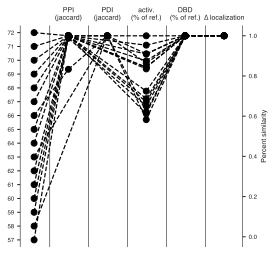

In [34]:
# Creating the figure and axes (subplots) aligned in a single row without shared y-axis
gs_kw = dict(width_ratios=[0.75, 1, 1, 1, 1, 1])
fig, axs = plt.subplots(1, 6, sharey=False, gridspec_kw=gs_kw)
fig.set_size_inches(w=4, h=4)
df = isos_sim

# Adjusting the space between subplots for better alignment of lines
fig.subplots_adjust(wspace=0.05)

# zorder of axis labels
plt.rcParams["axes.axisbelow"] = False

# Re-plotting each column in a separate subplot
for i, col in enumerate(columns_to_plot):
    axs[i].clear()  # Clear previous axes to avoid duplication
    axs[i].set_title(column_titles[i])  # Setting the title of the subplot to the column name
    axs[i].set_xticks([])  # Hide x-axis labels

    # Setting different limits for y-axis based on column data
    axs[i].set_ylim(np.nanmin(df[col]) - 0.1, np.nanmax(df[col]) + 0.1)
    
    j = 0
    black_js = []
    for name, cat in zip(df['clone_acc_alt'], df['dn_cat']):
        if name == "theoretical":
            color = "black"
            black_js.append(j)
        elif cat == "similar":
            color = "black"
            black_js.append(j)
        else:
            color = colors[j]
        
        # Mark the value with a dot
        axs[i].plot(0, df[col].iloc[j], color=color, marker='o', 
                    markersize=6)
        j += 1
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    
    if i == 0:
        axs[i].spines['right'].set_visible(False)
    elif i == 5:
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel("Percent similarity")
    else:
        axs[i].spines['right'].set_visible(False)
        axs[i].yaxis.set_tick_params(labelleft=False)
        axs[i].set_yticks([])

# Remove previous lines
fig.lines = []

# set axis limits
tickpos = list(df["level_0"])
axs[0].set_ylim((tickpos[0]-0.5), (tickpos[-1]+0.5))
axs[1].set_ylim((-0.05, 1.05))
axs[2].set_ylim((-0.05, 1.05))
axs[3].set_ylim((-0.05, 1.05))
axs[4].set_ylim((-0.05, 1.05))
axs[5].set_ylim((-0.05, 1.05))


# Data preparation for plotting
data_lines = []
for _, row in df.iterrows():
    data_lines.append([row[columns_to_plot[0]], row[columns_to_plot[1]], 
                       row[columns_to_plot[2]], row[columns_to_plot[3]],
                       row[columns_to_plot[4]], row[columns_to_plot[5]]])

# Re-connecting dots across subplots with lines
for j, data_line in enumerate(data_lines):
    if j in black_js:
        color = "black"
    else:
        color = colors[j]
        
    skip_flag = False
    
    # Adding lines between subplots; adjusting coordinates for subplot borders
    for k in range(len(axs)-1):
        # We use figure coordinates to draw lines between subplots
        transFigure = fig.transFigure.inverted()
        
        
        if not skip_flag:
            pt1_k = k
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
        
        # if we prev skipped due to na, keep the same pt1 and use current pt2
        else:
            pt1_k = k-1
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
            
        if np.isnan(pt2):
            #print("skip flag true")
            skip_flag = True
            continue
        else:
            skip_flag = False
        
        #print("pt1: %s | pt2: %s | ax1: %s | ax2: %s" % (pt1, pt2, pt1_k, pt2_k))
        
        # Get coordinates of the points in figure coordinate system
        coord1 = transFigure.transform(axs[pt1_k].transData.transform([0, pt1]))
        coord2 = transFigure.transform(axs[pt2_k].transData.transform([0, pt2]))

        # Calculate the space adjustment based on the subplot spacing
        #space_adjustment = 0.015 + 0.23 * k

        # Adding space adjustment to x-coordinate for accurate alignment
        line = plt.Line2D((coord1[0], coord2[0]), 
                          (coord1[1], coord2[1]), 
                          transform=fig.transFigure, color=color, linestyle="dashed")
        fig.add_artist(line)
        


# relabel ticks
ticklabels = list(isos["clone_acc_alt"])
axs[0].set_yticks(tickpos)
#_ = axs[0].set_yticklabels(ticklabels)

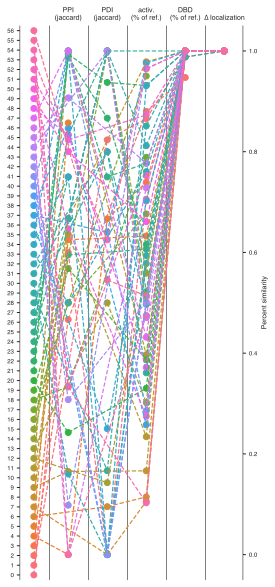

In [35]:
# Creating the figure and axes (subplots) aligned in a single row without shared y-axis
gs_kw = dict(width_ratios=[0.75, 1, 1, 1, 1, 1])
fig, axs = plt.subplots(1, 6, sharey=False, gridspec_kw=gs_kw)
fig.set_size_inches(w=4, h=10)
df = isos_rw

# Adjusting the space between subplots for better alignment of lines
fig.subplots_adjust(wspace=0.05)

# zorder of axis labels
plt.rcParams["axes.axisbelow"] = False

# Re-plotting each column in a separate subplot
for i, col in enumerate(columns_to_plot):
    axs[i].clear()  # Clear previous axes to avoid duplication
    axs[i].set_title(column_titles[i])  # Setting the title of the subplot to the column name
    axs[i].set_xticks([])  # Hide x-axis labels

    # Setting different limits for y-axis based on column data
    axs[i].set_ylim(np.nanmin(df[col]) - 0.1, np.nanmax(df[col]) + 0.1)
    
    j = 0
    black_js = []
    for name, cat in zip(df['clone_acc_alt'], df['dn_cat']):
        if name == "theoretical":
            color = "black"
            black_js.append(j)
        elif cat == "similar":
            color = "black"
            black_js.append(j)
        else:
            color = colors[j]
        
        # Mark the value with a dot
        axs[i].plot(0, df[col].iloc[j], color=color, marker='o', 
                    markersize=6)
        j += 1
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    
    if i == 0:
        axs[i].spines['right'].set_visible(False)
    elif i == 5:
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel("Percent similarity")
    else:
        axs[i].spines['right'].set_visible(False)
        axs[i].yaxis.set_tick_params(labelleft=False)
        axs[i].set_yticks([])

# Remove previous lines
fig.lines = []

# set axis limits
tickpos = list(df["level_0"])
axs[0].set_ylim((tickpos[0]-0.5), (tickpos[-1]+0.5))
axs[1].set_ylim((-0.05, 1.05))
axs[2].set_ylim((-0.05, 1.05))
axs[3].set_ylim((-0.05, 1.05))
axs[4].set_ylim((-0.05, 1.05))
axs[5].set_ylim((-0.05, 1.05))


# Data preparation for plotting
data_lines = []
for _, row in df.iterrows():
    data_lines.append([row[columns_to_plot[0]], row[columns_to_plot[1]], 
                       row[columns_to_plot[2]], row[columns_to_plot[3]],
                       row[columns_to_plot[4]], row[columns_to_plot[5]]])

# Re-connecting dots across subplots with lines
for j, data_line in enumerate(data_lines):
    if j in black_js:
        color = "black"
    else:
        color = colors[j]
        
    skip_flag = False
    
    # Adding lines between subplots; adjusting coordinates for subplot borders
    for k in range(len(axs)-1):
        # We use figure coordinates to draw lines between subplots
        transFigure = fig.transFigure.inverted()
        
        
        if not skip_flag:
            pt1_k = k
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
        
        # if we prev skipped due to na, keep the same pt1 and use current pt2
        else:
            pt1_k = k-1
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
            
        if np.isnan(pt2):
            #print("skip flag true")
            skip_flag = True
            continue
        else:
            skip_flag = False
        
        #print("pt1: %s | pt2: %s | ax1: %s | ax2: %s" % (pt1, pt2, pt1_k, pt2_k))
        
        # Get coordinates of the points in figure coordinate system
        coord1 = transFigure.transform(axs[pt1_k].transData.transform([0, pt1]))
        coord2 = transFigure.transform(axs[pt2_k].transData.transform([0, pt2]))

        # Calculate the space adjustment based on the subplot spacing
        #space_adjustment = 0.015 + 0.23 * k

        # Adding space adjustment to x-coordinate for accurate alignment
        line = plt.Line2D((coord1[0], coord2[0]), 
                          (coord1[1], coord2[1]), 
                          transform=fig.transFigure, color=color, linestyle="dashed")
        fig.add_artist(line)
        


# relabel ticks
ticklabels = list(isos["clone_acc_alt"])
axs[0].set_yticks(tickpos)
#_ = axs[0].set_yticklabels(ticklabels)

## 4. summary plots of DN categorization

In [36]:
pairs["dn_short"] = pairs["dn_cat"].str.split(" ", expand=True)[0]
pairs.dn_short.value_counts()

dn_short
NA         272
DN         102
rewire      57
similar     15
likely       1
Name: count, dtype: int64

In [37]:
pairs[pairs["dn_short"] == "likely"]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,combined_cat_U2OS,condensate_or_loc_change_both,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS,loc_cat_HEK,loc_cat_U2OS,loc_cat,dn_cat,dn_cat_plus_loc,dn_short
70,PPARG,ENSG00000132170,Nuclear receptor,True,PPARG|1/4|10G02,PPARG|3/4|01H02,ENST00000287820,NaN,False,True,...,Same localization and condensate formation,No difference,CC -> BOTH,CC -> BOTH,no localization change,no localization change,no localization change,likely nf,likely nf,likely


In [38]:
pairs[pairs["dn_cat"] == "DN (loc loss)"]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,combined_cat_U2OS,condensate_or_loc_change_both,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS,loc_cat_HEK,loc_cat_U2OS,loc_cat,dn_cat,dn_cat_plus_loc,dn_short
131,TFAP2A,ENSG00000137203,AP-2,True,TFAP2A|2/4|09G07,TFAP2A|3/4|09D06,ENST00000379613|ENST00000482890,ENST00000319516,False,False,...,Same localization and condensate formation,NaN,BOTH -> CC,BOTH -> BOTH,localization loss,no localization change,localization loss,DN (loc loss),DN (loc loss),DN
357,TCF4,ENSG00000196628,bHLH,True,TCF4|1/9|07E01,TCF4|8/9|07A05,ENST00000354452|ENST00000629387,ENST00000561831,False,False,...,Difference in localization,Difference,NC -> CC,NC -> CC,localization loss,localization loss,localization loss,DN (loc loss),DN (loc loss),DN


In [39]:
pairs[pairs["gene_symbol"] == "FOXP2"][["gene_symbol", "clone_acc_alt", "clone_acc_ref",
                                        "m1h_cat", "y1h_cat", "y2h_cat", "loc_cat", "dn_cat_plus_loc"]]

,gene_symbol,clone_acc_alt,clone_acc_ref,m1h_cat,y1h_cat,y2h_cat,loc_cat,dn_cat_plus_loc
149,FOXP2,FOXP2|1/10|07C01,FOXP2|2/10|07B01,similar,NA,PPI rewire,no localization change,rewire
150,FOXP2,FOXP2|4/10|12A06,FOXP2|2/10|07B01,rewire,NA,PPI rewire,no localization change,rewire
151,FOXP2,FOXP2|10/10|06A10,FOXP2|2/10|07B01,rewire,NA,PPI loss: all,no localization change,"DN (PPIs,DBD loss)"
152,FOXP2,FOXP2|6/10|06F12,FOXP2|2/10|07B01,activation loss,NA,NA,localization loss,NA
153,FOXP2,FOXP2|7/10|06G10,FOXP2|2/10|07B01,NA,NA,PPI loss: signalling,localization loss,NA


In [40]:
def mech_bool(row, mech_col):
    if "DN" in row.dn_cat:
        if mech_col in row.dn_cat:
            return True
        else:
            return False
    else:
        return np.nan
    
pairs["dn_ppi"] = pairs.apply(mech_bool, mech_col="PPIs", axis=1)
pairs["dn_pdi"] = pairs.apply(mech_bool, mech_col="PDIs", axis=1)
pairs["dn_activ"] = pairs.apply(mech_bool, mech_col="activ", axis=1)
pairs["dn_dbd"] = pairs.apply(mech_bool, mech_col="DBD loss", axis=1)
pairs["dn_loc"] = pairs.apply(mech_bool, mech_col="loc loss", axis=1)
pairs[pairs["dn_short"] == "DN"].sample(5)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,loc_cat_U2OS,loc_cat,dn_cat,dn_cat_plus_loc,dn_short,dn_ppi,dn_pdi,dn_activ,dn_dbd,dn_loc
225,ZBTB44,ENSG00000196323,C2H2 ZF,False,ZBTB44|1/9|12B06,ZBTB44|3/9|10B06,ENST00000357899|ENST00000397753,ENST00000525842,False,False,...,NA,NA,DN (DBD loss),DN (DBD loss),DN,False,False,False,True,False
48,ATF2,ENSG00000115966,bZIP,True,ATF2|1/6|12H04,ATF2|3/6|09C05,ENST00000264110|ENST00000392544,ENST00000345739|ENST00000409635,False,False,...,no localization change,no localization change,DN (PPIs),DN (PPIs),DN,True,False,False,False,False
258,FOXN4,ENSG00000139445,Forkhead,False,FOXN4|1/2|10F06,FOXN4|2/2|10A07,ENST00000299162,ENST00000355216,False,False,...,no localization change,no localization change,DN (PPIs),DN (PPIs),DN,True,False,False,False,False
5,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,...,no localization change,no localization change,DN (PPIs),DN (PPIs),DN,True,False,False,False,False
337,TP53,ENSG00000141510,p53,True,TP53|1/2|11G10,TP53|2/2|02F03,ENST00000269305|ENST00000445888,ENST00000610292|ENST00000619485|ENST00000620739,False,False,...,no localization change,no localization change,DN (PPIs),DN (PPIs),DN,True,False,False,False,False


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


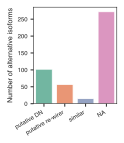

In [41]:
fig = plt.figure(figsize=(1.5, 1.75))

ax = sns.countplot(data=pairs, x="dn_short", palette=sns.color_palette("Set2"),
                   order=["DN", "rewire", "similar", "NA"])
ax.set_xticklabels(["putative DN", "putative re-wirer", "similar", "NA"], ha="right", va="top", rotation=30)
ax.set_xlabel("")
ax.set_ylabel("Number of alternative isoforms")

fig.savefig("../../figures/fig7/DN_countplot.pdf", dpi="figure", bbox_inches="tight")

100


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


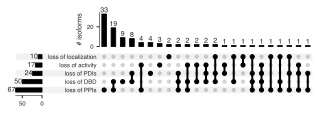

In [42]:
ppis = list(set(list(pairs[pairs["dn_ppi"] == True]["clone_acc_alt"])))
pdis = list(set(list(pairs[pairs["dn_pdi"] == True]["clone_acc_alt"])))
activ = list(set(list(pairs[pairs["dn_activ"] == True]["clone_acc_alt"])))
dbd = list(set(list(pairs[pairs["dn_dbd"] == True]["clone_acc_alt"])))
loc = list(set(list(pairs[pairs["dn_loc"] == True]["clone_acc_alt"])))

contents = {"loss of PPIs": ppis, "loss of PDIs": pdis, "loss of activity": activ, "loss of DBD": dbd,
            "loss of localization": loc}
contents = upsetplot.from_contents(contents)

all_dn = set(ppis).union(set(pdis)).union(set(activ)).union(set(dbd))
print(len(all_dn))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
     intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../../figures/fig7/DN_negreg_upset.pdf", dpi="figure", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


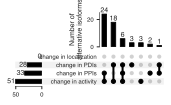

In [43]:
rw = pairs[pairs["dn_cat"] == "rewire"]
ppis = list(set(list(rw[rw["y2h_cat"] == "PPI rewire"]["clone_acc_alt"])))
pdis = list(set(list(rw[rw["y1h_cat"].str.contains("PDI")]["clone_acc_alt"])))
activ = list(set(list(rw[rw["m1h_cat"] != "NA"]["clone_acc_alt"])))
loc = list(set(list(rw[rw["loc_cat"] == "localization change"]["clone_acc_alt"])))

contents = {"change in PPIs": ppis, "change in PDIs": pdis, "change in activity": activ, 
            "change in localization": loc}
contents = upsetplot.from_contents(contents)

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
         intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("Number of\nalternative isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../../figures/fig7/DN_rewire_upset.pdf", dpi="figure", bbox_inches="tight")

362


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


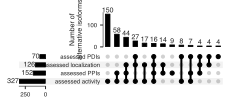

In [44]:
ppis = list(set(list(pairs[pairs["y2h_cat"] != "NA"]["clone_acc_alt"])))
pdis = list(set(list(pairs[pairs["y1h_cat"] != "NA"]["clone_acc_alt"])))
activ = list(set(list(pairs[pairs["m1h_cat"] != "NA"]["clone_acc_alt"])))
loc = list(set(list(pairs[pairs["loc_cat"] != "NA"]["clone_acc_alt"])))

contents = {"assessed PPIs": ppis, "assessed PDIs": pdis, "assessed activity": activ, "assessed localization": loc}
contents = upsetplot.from_contents(contents)

all_as = set(ppis).union(set(pdis)).union(set(activ))
print(len(all_as))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
         intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("Number of\nalternative isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../../figures/fig7/DN_pairs_assessed_upset.pdf", dpi="figure", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


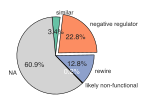

In [45]:
y = np.array([len(pairs[pairs["dn_short"] == "rewire"]), 
              len(pairs[pairs["dn_short"] == "DN"]),
              len(pairs[pairs["dn_short"] == "similar"]),
              len(pairs[pairs["dn_short"] == "NA"]), 
              len(pairs[pairs["dn_short"] == "likely"])])
labels = ["rewire", "negative regulator", "similar", "NA", "likely non-functional"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], sns.color_palette("Set2")[0],
          "lightgray", "darkgray"]

fig = plt.figure(figsize=(1.75, 1.75))
ws, ls, ns = plt.pie(y, labels=labels, colors=colors, autopct='%1.1f%%', startangle=-45, explode=(0, 0.1, 0, 0, 0))
for w in ws:
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
ns[4].set_color("white")

fig.savefig("../../figures/fig7/dn_pie.incl_NA.pdf", dpi="figure", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


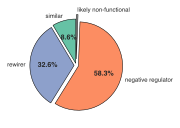

In [46]:
ys = np.array([len(pairs[pairs["dn_short"] == "similar"]),
               len(pairs[pairs["dn_short"] == "rewire"]), 
               len(pairs[pairs["dn_short"] == "DN"]),
               len(pairs[pairs["dn_short"] == "likely"])])
labels = ["similar", "rewirer", "negative regulator", "likely non-functional"]
colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], "darkgray"]

fig, ax = plt.subplots(figsize=(2.0, 2.0), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, 
                    explode=(0.05, 0.05, 0.05, 0.15))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")
ns[3].set_text("")

fig.savefig("../../figures/fig7/dn_pie.no_NA.pdf", dpi="figure", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


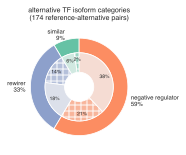

In [47]:
outer_ys = np.array([len(pairs[(pairs["dn_short"] == "similar")]),
                     len(pairs[(pairs["dn_short"] == "rewire")]), 
                     len(pairs[(pairs["dn_short"] == "DN")])])
outer_labels = ["similar\n%0.0f%%" % round((outer_ys[0]/np.sum(outer_ys)*100)),
                "rewirer\n%0.0f%%" % round((outer_ys[1]/np.sum(outer_ys)*100)), 
                "negative regulator\n%0.0f%%" % round((outer_ys[2]/np.sum(outer_ys)*100))]
outer_colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2], sns.color_palette("Set2")[1]]

inner_ys = np.array([len(pairs[(pairs["dn_short"] == "similar") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "similar") & (~pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "rewire") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "rewire") & (~pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "DN") & (pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "DN") & (~pairs["is_alt_novel_isoform"])])])
inner_colors = [sns.light_palette(sns.color_palette("Set2")[0])[3], 
                sns.light_palette(sns.color_palette("Set2")[0])[1], 
                sns.light_palette(sns.color_palette("Set2")[2])[3], 
                sns.light_palette(sns.color_palette("Set2")[2])[1], 
                sns.light_palette(sns.color_palette("Set2")[1])[3], 
                sns.light_palette(sns.color_palette("Set2")[1])[1]]
hatches = ['++', '', '++', '', '++', '']


fig, ax = plt.subplots(figsize=(2.2, 2.2), subplot_kw=dict(aspect="equal"))

o_ws, o_ls = ax.pie(outer_ys, colors=outer_colors, labels=outer_labels,
                    startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))
i_ws, i_ls, i_ns = ax.pie(inner_ys, colors=inner_colors, autopct='%0.0f%%', 
                          startangle=90, radius=0.7, 
                          wedgeprops=dict(width=0.4, edgecolor='w'),
                          textprops={'fontsize': 5}, pctdistance=0.8)

for i, w in enumerate(i_ws):
    w.set(hatch=hatches[i])
    
ax.set_title("alternative TF isoform categories\n(%s reference-alternative pairs)" % (np.sum(outer_ys)))

fig.savefig("../../figures/fig7/dn_pie.novel_nested.pdf", dpi="figure", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


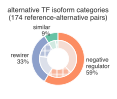

In [48]:
outer_ys = np.array([len(pairs[(pairs["dn_short"] == "similar")]),
                     len(pairs[(pairs["dn_short"] == "rewire")]), 
                     len(pairs[(pairs["dn_short"] == "DN")])])
outer_labels = ["similar\n%0.0f%%" % round((outer_ys[0]/np.sum(outer_ys)*100)),
                "rewirer\n%0.0f%%" % round((outer_ys[1]/np.sum(outer_ys)*100)), 
                "negative\nregulator\n%0.0f%%" % round((outer_ys[2]/np.sum(outer_ys)*100))]
outer_colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2], sns.color_palette("Set2")[1]]

inner_ys = np.array([len(pairs[(pairs["dn_short"] == "similar") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "similar") & (~pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "rewire") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "rewire") & (~pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "DN") & (pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "DN") & (~pairs["is_alt_novel_isoform"])])])
inner_colors = [sns.light_palette(sns.color_palette("Set2")[0])[3], 
                sns.light_palette(sns.color_palette("Set2")[0])[1], 
                sns.light_palette(sns.color_palette("Set2")[2])[3], 
                sns.light_palette(sns.color_palette("Set2")[2])[1], 
                sns.light_palette(sns.color_palette("Set2")[1])[3], 
                sns.light_palette(sns.color_palette("Set2")[1])[1]]
hatches = ['++', '', '++', '', '++', '']


fig, ax = plt.subplots(figsize=(1.2, 1.2), subplot_kw=dict(aspect="equal"))

o_ws, o_ls = ax.pie(outer_ys, colors=outer_colors, labels=outer_labels,
                    startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))
i_ws, i_ns = ax.pie(inner_ys, colors=inner_colors, 
                          startangle=90, radius=0.7, 
                          wedgeprops=dict(width=0.3, edgecolor='w'))

for i, w in enumerate(i_ws):
    w.set(hatch=hatches[i])
    
ax.set_title("alternative TF isoform categories\n(%s reference-alternative pairs)" % (np.sum(outer_ys)))

fig.savefig("../../figures/fig7/dn_pie.novel_nested.no_labels.pdf", dpi="figure", bbox_inches="tight")

In [49]:
# create df that contains info about why alt isos were sorted into a particular category
# for DNs, include loss of DBD
tmp = pairs[pairs["dn_short"] == "DN"]
dn_pdi_change = len(tmp[tmp["dn_pdi"] == True])
dn_ppi_change = len(tmp[tmp["dn_ppi"] == True])
dn_activ_change = len(tmp[tmp["dn_activ"] == True])
dn_dbd_change = len(tmp[tmp["dn_dbd"] == True])
dn_loc_change = len(tmp[tmp["dn_loc"] == True])
tot_dn = len(tmp)

# for rewirers, include change in DBD (all will be <10% else they'd be DNs)
tmp = pairs[pairs["dn_short"] == "rewire"]
rw_pdi_change = len(tmp[~tmp["y1h_cat"].isin(["NA", "no PDI change"])])
rw_ppi_change = len(tmp[~tmp["y2h_cat"].isin(["NA", "no PPI change (important PPIs)"])])
rw_activ_change = len(tmp[~tmp["m1h_cat"].isin(["NA", "similar"])])
rw_dbd_change = len(tmp[tmp["dbd_pct_lost"] > 0])
rw_loc_change = len(tmp[tmp["loc_cat"] == "localization change"])
tot_rw = len(tmp)

# then include all assessed among categorized
tmp = pairs[pairs["dn_short"] != "NA"]
pdi_assessed = len(tmp[tmp["y1h_cat"] != "NA"])
ppi_assessed = len(tmp[tmp["y2h_cat"] != "NA"])
activ_assessed = len(tmp[tmp["m1h_cat"] != "NA"])
dbd_assessed = len(tmp[~pd.isnull(tmp["dbd_pct_lost"])])
loc_assessed = len(tmp[tmp["loc_cat"] != "NA"])
tot_assessed = len(tmp)

df = pd.DataFrame.from_dict({"DN": {"pdi": dn_pdi_change/tot_dn*100, 
                                    "ppi": dn_ppi_change/tot_dn*100,
                                    "activ": dn_activ_change/tot_dn*100, 
                                    "dbd": dn_dbd_change/tot_dn*100,
                                    "loc": dn_loc_change/tot_dn*100},
                             "rewire": {"pdi": rw_pdi_change/tot_rw*100,
                                        "ppi": rw_ppi_change/tot_rw*100,
                                        "activ": rw_activ_change/tot_rw*100,
                                        "dbd": rw_dbd_change/tot_rw*100,
                                        "loc": rw_loc_change/tot_rw*100},
                             "assessed": {"pdi": pdi_assessed/tot_assessed*100, 
                                    "ppi": ppi_assessed/tot_assessed*100,
                                    "activ": activ_assessed/tot_assessed*100,
                                          "dbd": dbd_assessed/tot_assessed*100,
                                          "loc": loc_assessed/tot_assessed*100}})

df = df.reset_index()
df

,index,DN,rewire,assessed
0,pdi,23.529412,38.596491,38.285714
1,ppi,65.686275,66.666667,77.142857
2,activ,16.666667,33.333333,91.428571
3,dbd,49.019608,5.263158,93.714286
4,loc,9.803922,0.000000,55.428571


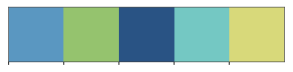

In [50]:
colors = met_brewer.met_brew(name="Hokusai3", n=5, brew_type="discrete")
sns.palplot(colors)

In [51]:
to_plot = pd.melt(df, id_vars="index")
to_plot

,index,variable,value
0,pdi,DN,23.529412
1,ppi,DN,65.686275
2,activ,DN,16.666667
3,dbd,DN,49.019608
4,loc,DN,9.803922
5,pdi,rewire,38.596491
6,ppi,rewire,66.666667
7,activ,rewire,33.333333
8,dbd,rewire,5.263158
9,loc,rewire,0.000000


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


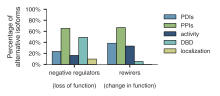

In [52]:
fig = plt.figure(figsize=(2, 1))

ax = sns.barplot(data=to_plot, x="variable", y="value", hue="index", palette=colors,
                 order=["DN", "rewire"], edgecolor="black", linewidth=0.5,
                 hue_order=["pdi", "ppi", "activ", "dbd", "loc"])

ax.set_xlabel("")
ax.set_xticklabels(["negative regulators\n\n(loss of function)", "rewirers\n\n(change in function)"])

# # Define some hatches
# hatches = ['', 'xxxx', '', '', 'xxxx', '', '', 'xxxx', '', '', 'xxxx', '', '', 'xxxx', '']
# fills = ['', '', 'white', '', '', 'white', '', '', 'white', '', '', 'white', '', '', 'white']
# mpl.rcParams['hatch.linewidth'] = 0.5

# # Loop over the bars
# for i, bar in enumerate(ax.patches):
#     # Set a different hatch for each bar
#     bar.set_hatch(hatches[i])
#     fill = fills[i]
#     if fill == "white":
#         bar.set_alpha(0.5)

handles, previous_labels = ax.get_legend_handles_labels()
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False,
           handles=handles, labels=["PDIs", "PPIs", "activity", "DBD", "localization"])

ax.set_ylim((0, 100))
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
ax.set_ylabel("Percentage of\nalternative isoforms")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/dn_function_unstacked_bar.pdf", dpi="figure", bbox_inches="tight")

In [53]:
genes_w_dn = pairs[pairs["dn_short"] == "DN"][["gene_symbol", "family"]].drop_duplicates()
genes_w_rw = pairs[pairs["dn_short"] == "rewire"][["gene_symbol", "family"]].drop_duplicates()
genes_w_sim = pairs[pairs["dn_short"] == "similar"][["gene_symbol", "family"]].drop_duplicates()
tot_genes = pairs[["gene_symbol", "family"]].drop_duplicates()

tot_genes_per_f = tot_genes.groupby("family")["gene_symbol"].agg("count").reset_index()
dn_genes_per_f = genes_w_dn.groupby("family")["gene_symbol"].agg("count").reset_index()
rw_genes_per_f = genes_w_rw.groupby("family")["gene_symbol"].agg("count").reset_index()
sim_genes_per_f = genes_w_sim.groupby("family")["gene_symbol"].agg("count").reset_index()

family_cats = tot_genes_per_f.merge(dn_genes_per_f, 
                                    on="family", how="left")
family_cats = family_cats.merge(rw_genes_per_f, 
                                on="family", how="left").merge(sim_genes_per_f,
                                                               on="family",
                                                               how="left", suffixes=("_a", "_b"))
family_cats.fillna(0, inplace=True)
family_cats.columns = ["family", "tot", "dn", "rw", "sim"]

family_cats["tot_p"] = family_cats["tot"]/family_cats["tot"].sum(axis=0)*100
family_cats["dn_p"] = family_cats["dn"]/family_cats["dn"].sum(axis=0)*100
family_cats["rw_p"] = family_cats["rw"]/family_cats["rw"].sum(axis=0)*100
family_cats["sim_p"] = family_cats["sim"]/family_cats["sim"].sum(axis=0)*100
family_cats.sort_values(by="tot", ascending=False).head(11)
family_cats

,family,tot,dn,rw,sim,tot_p,dn_p,rw_p,sim_p
0,AP-2,1,1.0,1.0,0.0,0.406504,1.369863,2.380952,0.000000
1,AT hook,1,0.0,0.0,0.0,0.406504,0.000000,0.000000,0.000000
2,C2H2 ZF,101,15.0,11.0,2.0,41.056911,20.547945,26.190476,13.333333
3,C2H2 ZF; AT hook,1,1.0,0.0,0.0,0.406504,1.369863,0.000000,0.000000
4,C2H2 ZF; BED ZF,1,0.0,0.0,0.0,0.406504,0.000000,0.000000,0.000000
5,CBF/NF-Y,1,0.0,1.0,0.0,0.406504,0.000000,2.380952,0.000000
6,CCCH ZF,1,0.0,0.0,0.0,0.406504,0.000000,0.000000,0.000000
7,CSL,1,0.0,1.0,1.0,0.406504,0.000000,2.380952,6.666667
8,CxxC,1,0.0,0.0,0.0,0.406504,0.000000,0.000000,0.000000
9,E2F,4,2.0,0.0,0.0,1.626016,2.739726,0.000000,0.000000


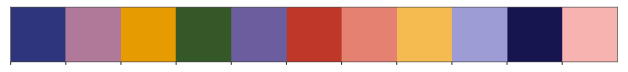

In [54]:
colors = met_brewer.met_brew(name="Renoir", n=11, brew_type="discrete")
sns.palplot(colors)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


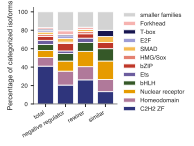

In [55]:
fig, ax = plt.subplots(figsize=(1.5, 1.75))

xs = ["total", "negative regulator", "rewirer", "similar"]

b = np.zeros(4)
c = 0
for i, row in family_cats.sort_values(by="tot", ascending=False).head(11).iterrows():
    y = list(row[["tot_p", "dn_p", "rw_p", "sim_p"]])
    ax.bar(xs, y, bottom=b, label=row.family, color=colors[c])
    b = np.add(b, y)
    c += 1

ax.bar(xs, np.subtract([100, 100, 100, 100], b), bottom=b, label="smaller families", color="lightgray")
ax.set_ylabel("Percentage of categorized isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/dn_families_stacked_bar.pdf", dpi="figure", bbox_inches="tight")

## 5. are there differences in condensate formation between categories?

In [56]:
def condensate_cat_either(row):
    if row.condensate_cat_only_HEK == "Difference" or row.condensate_cat_only_U2OS == "Difference":
        return "Difference"
    elif row.condensate_cat_only_HEK == "No difference" and row.condensate_cat_only_U2OS == "No difference":
        return "No difference"
    elif row.condensate_cat_only_HEK == "No difference" or row.condensate_cat_only_U2OS == "No difference":
        return "No difference"
    else:
        return np.nan
    
pairs["condensate_cat_either"] = pairs.apply(condensate_cat_either, axis=1)
pairs.condensate_cat_either.value_counts()

condensate_cat_either
No difference    89
Difference       40
Name: count, dtype: int64

In [57]:
def condensate_cat_both(row):
    if row.condensate_cat_only_HEK == "Difference" and row.condensate_cat_only_U2OS == "Difference":
        return "Difference"
    elif row.condensate_cat_only_HEK == "No difference" and row.condensate_cat_only_U2OS == "No difference":
        return "No difference"
    else:
        return np.nan
    
pairs["condensate_cat_both"] = pairs.apply(condensate_cat_both, axis=1)
pairs.condensate_cat_both.value_counts()

condensate_cat_both
No difference    88
Difference       19
Name: count, dtype: int64

In [58]:
from scipy.stats import fisher_exact

In [59]:
fe = np.zeros((2, 2))

tmp_nonan = pairs[~pd.isnull(pairs["condensate_cat_either"])]

fe[0, 0] = len(tmp_nonan[(tmp_nonan["dn_short"] == "DN") & 
                    (tmp_nonan["condensate_cat_either"] == "Difference")].clone_acc_alt.unique())
fe[1, 0] = len(tmp_nonan[(tmp_nonan["dn_short"] != "DN") & 
                    (tmp_nonan["condensate_cat_either"] == "Difference")].clone_acc_alt.unique())
fe[0, 1] = len(tmp_nonan[(tmp_nonan["dn_short"] == "DN") &
                    (tmp_nonan["condensate_cat_either"] == "No difference")].clone_acc_alt.unique())
fe[1, 1] = len(tmp_nonan[(tmp_nonan["dn_short"] != "DN") & 
                    (tmp_nonan["condensate_cat_either"] == "No difference")].clone_acc_alt.unique())
fe

array([[19., 37.],
       [21., 52.]])

In [60]:
p = fisher_exact(fe)[1]
print(p)

0.5681779408501834


In [61]:
tots = pd.DataFrame(tmp_nonan.dn_short.value_counts())
sig = pd.DataFrame(tmp_nonan[tmp_nonan["condensate_cat_either"] == "Difference"].dn_short.value_counts())
con_st = tots.join(sig, lsuffix="_tot", rsuffix="_diff")
con_st = con_st.loc[["DN", "rewire", "similar", "NA"]]
con_st = con_st/con_st.sum(axis=0)
con_st.fillna(0, inplace=True)
con_st

,count_tot,count_diff
dn_short,,
DN,0.437500,0.475
rewire,0.281250,0.275
similar,0.046875,0.075
NA,0.234375,0.175


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


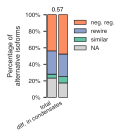

In [62]:
fig, ax = plt.subplots(figsize=(0.4, 1.5))

xs = ["total", "diff. in condensates"]
y1 = list(con_st[["count_tot", "count_diff"]].loc["NA"])
y2 = list(con_st[["count_tot", "count_diff"]].loc["similar"])
b2 = np.add(y1, y2)
y3 = list(con_st[["count_tot", "count_diff"]].loc["rewire"])
b3 = np.add(b2, y3)
y4 = list(con_st[["count_tot", "count_diff"]].loc["DN"])

ax.bar(xs, y1, color=dn_pal["NA"], label="NA", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=dn_pal["similar"], label="similar", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=dn_pal["rewire"], label="rewire", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=dn_pal["DN"], label="neg. reg.", edgecolor="black", linewidth=0.5)

# annotate pval
annotate_pval(ax, 0, 1, 1.025, 0, 1.025, p, fontsize-1)

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("Percentage of\nalternative isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])
ax.set_ylim(0, 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

fig.savefig("../../figures/fig7/dn_stacked_bar_condensates.either.pdf", dpi="figure", bbox_inches="tight")

In [63]:
fe = np.zeros((2, 2))

tmp_nonan = pairs[~pd.isnull(pairs["condensate_cat_both"])]

fe[0, 0] = len(tmp_nonan[(tmp_nonan["dn_short"] == "DN") & 
                    (tmp_nonan["condensate_cat_both"] == "Difference")].clone_acc_alt.unique())
fe[1, 0] = len(tmp_nonan[(tmp_nonan["dn_short"] != "DN") & 
                    (tmp_nonan["condensate_cat_both"] == "Difference")].clone_acc_alt.unique())
fe[0, 1] = len(tmp_nonan[(tmp_nonan["dn_short"] == "DN") &
                    (tmp_nonan["condensate_cat_both"] == "No difference")].clone_acc_alt.unique())
fe[1, 1] = len(tmp_nonan[(tmp_nonan["dn_short"] != "DN") & 
                    (tmp_nonan["condensate_cat_both"] == "No difference")].clone_acc_alt.unique())
fe

array([[ 9., 37.],
       [10., 51.]])

In [64]:
p = fisher_exact(fe)[1]
print(p)

0.7993098847754758


In [65]:
tots = pd.DataFrame(tmp_nonan.dn_short.value_counts())
sig = pd.DataFrame(tmp_nonan[tmp_nonan["condensate_cat_both"] == "Difference"].dn_short.value_counts())
con_st = tots.join(sig, lsuffix="_tot", rsuffix="_diff")
con_st = con_st.loc[["DN", "rewire", "similar", "NA"]]
con_st = con_st/con_st.sum(axis=0)
con_st.fillna(0, inplace=True)
con_st

,count_tot,count_diff
dn_short,,
DN,0.433962,0.473684
rewire,0.273585,0.210526
similar,0.037736,0.052632
NA,0.254717,0.263158


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


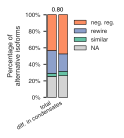

In [66]:
fig, ax = plt.subplots(figsize=(0.4, 1.5))

xs = ["total", "diff. in condensates"]
y1 = list(con_st[["count_tot", "count_diff"]].loc["NA"])
y2 = list(con_st[["count_tot", "count_diff"]].loc["similar"])
b2 = np.add(y1, y2)
y3 = list(con_st[["count_tot", "count_diff"]].loc["rewire"])
b3 = np.add(b2, y3)
y4 = list(con_st[["count_tot", "count_diff"]].loc["DN"])

ax.bar(xs, y1, color=dn_pal["NA"], label="NA", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=dn_pal["similar"], label="similar", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=dn_pal["rewire"], label="rewire", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=dn_pal["DN"], label="neg. reg.", edgecolor="black", linewidth=0.5)

# annotate pval
annotate_pval(ax, 0, 1, 1.025, 0, 1.025, p, fontsize-1)

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("Percentage of\nalternative isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])
ax.set_ylim(0, 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0)

fig.savefig("../../figures/fig7/dn_stacked_bar_condensates.both.pdf", dpi="figure", bbox_inches="tight")

## 6. plot expression profiles of isoform categories

In [67]:
# use same downsample as prev figs
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

In [68]:
# calculate expression ratios - dev
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100

In [69]:
# calculate expression ratios - gtex
per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100

In [70]:
# calculate expression ratios -gtex downsampled
per_gene_gtex_ds = ((2 ** df_gtex.loc[:,metadata_gtex_dummy.index] - 1)
                   .groupby(genes_gtex)
                   .transform('sum'))

f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100

In [71]:
# calculate gene-level tissue specificities
gene_dev_nonan_taus, gene_dev_nan_taus, gene_dev_array_max = calculate_tau(per_gene_dev.drop_duplicates())
gene_gtex_nonan_taus, gene_gtex_nan_taus, gene_gtex_array_max = calculate_tau(per_gene_gtex.drop_duplicates())
gene_gtex_ds_nonan_taus, gene_gtex_ds_nan_taus, gene_gtex_ds_array_max = calculate_tau(per_gene_gtex_ds.drop_duplicates())

In [72]:
gene_taus = pd.DataFrame()
gene_taus["UID"] = per_gene_dev.drop_duplicates().index
gene_taus["dev_tau"] = gene_dev_nan_taus
gene_taus["gtex_tau"] = gene_gtex_nan_taus
gene_taus["gtex_ds_tau"] = gene_gtex_ds_nan_taus
gene_taus["gene_name"] = gene_taus["UID"].str.split("|", expand=True)[0]
gene_taus.sample(5)

,UID,dev_tau,gtex_tau,gtex_ds_tau,gene_name
236,ZNF747|1/4|03E01 ZNF747-203,0.556789,0.557651,0.511856,ZNF747
136,STAT1|1/7|01B05 STAT1-201_STAT1-204,0.927637,0.939912,0.950045,STAT1
241,ZSCAN21|1/3|10H09 ZSCAN21-201,0.497534,0.723863,0.734079,ZSCAN21
42,FOXP2|1/10|07C01 FOXP2-211,0.978752,0.896384,0.875115,FOXP2
63,IRF5|1/5|07C09 IRF5-202_IRF5-213,0.932762,0.948421,0.947206,IRF5


In [73]:
# join w pairs table
dev_ratios = f_dev.reset_index()
dev_ratios["clone_acc"] = dev_ratios["UID"].str.split(" ", expand=True)[0].astype(str)
dev_ratios = dev_ratios[dev_ratios["clone_acc"] != "noclone"]
len(dev_ratios)

693

In [74]:
gtex_ratios = f_gtex.reset_index()
gtex_ratios["clone_acc"] = gtex_ratios["UID"].str.split(" ", expand=True)[0].astype(str)
gtex_ratios = gtex_ratios[gtex_ratios["clone_acc"] != "noclone"]
len(gtex_ratios)

693

In [75]:
gtex_ds_ratios = f_gtex_downsample.reset_index()
gtex_ds_ratios["clone_acc"] = gtex_ds_ratios["UID"].str.split(" ", expand=True)[0].astype(str)
gtex_ds_ratios = gtex_ds_ratios[gtex_ds_ratios["clone_acc"] != "noclone"]
len(gtex_ds_ratios)

693

In [76]:
dn_ref = pairs[["gene_symbol", "family", "clone_acc_ref", "is_ref_novel_isoform", "is_MANE_select_isoform_cloned",
             "dn_short"]].drop_duplicates()
dn_ref.columns = ["gene_name", "family", "tf1p0_id", "is_novel", "is_MANE_select", "dn_cat"]
dn_ref["dn_cat"] = "ref"
dn_ref["iso_status"] = "ref"

In [77]:
dn_alt = pairs[["gene_symbol", "family", "clone_acc_alt", "is_alt_novel_isoform", "is_MANE_select_isoform_cloned",
             "dn_short"]].drop_duplicates()
dn_alt.columns = ["gene_name", "family", "tf1p0_id", "is_novel", "is_MANE_select", "dn_cat"]
dn_alt["is_MANE_select"] = False # assuming none of the alts are the MANE select
dn_alt["iso_status"] = "alt"

In [78]:
dn_cats = pd.concat([dn_ref, dn_alt]).drop_duplicates()

In [79]:
dev_ratios = dev_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
gtex_ratios = gtex_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
gtex_ds_ratios = gtex_ds_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
print(len(dev_ratios))
print(len(gtex_ratios))
print(len(gtex_ds_ratios))

693
693
693


In [80]:
dn_cats = dn_cats.merge(gene_taus, on="gene_name")
print(len(dn_cats))
dn_cats.head()

693


,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,UID,dev_tau,gtex_tau,gtex_ds_tau
0,ZBTB18,C2H2 ZF,ZBTB18|1/2|04E08,False,True,ref,ref,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.942517
1,ZBTB18,C2H2 ZF,ZBTB18|2/2|12E05,False,False,rewire,alt,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.942517
2,PRRX1,Homeodomain,PRRX1|2/3|09F06,False,True,ref,ref,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.864841
3,PRRX1,Homeodomain,PRRX1|1/3|09C07,False,False,NA,alt,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.864841
4,PRRX1,Homeodomain,PRRX1|3/3|09H08,False,False,similar,alt,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.864841


In [81]:
ref_expr = dn_cats.groupby(["gene_name", "family", "dn_cat", "dev_tau",
                            "gtex_tau", "gtex_ds_tau"])["tf1p0_id"].agg("count").reset_index()
ref_expr = ref_expr.pivot(index="gene_name",
                          columns="dn_cat", values="tf1p0_id")
ref_expr.fillna(0, inplace=True)

In [82]:
def categorize_gene(row):
    if row.DN > 0 and row.rewire == 0 and row.similar == 0:
        return "DN"
    elif row.rewire > 0 and row.DN == 0 and row.similar == 0:
        return "rewire"
    elif row.similar > 0 and row.DN == 0 and row.rewire == 0:
        return "similar"
    elif row.NA > 0:
        return "NA"
    else:
        return "combination"
    
ref_expr["gene_cat"] = ref_expr.apply(categorize_gene, axis=1)
ref_expr.reset_index(inplace=True)
ref_expr = ref_expr.merge(dn_cats[["gene_name", "family", "dev_tau", "gtex_tau", "gtex_ds_tau"]],
                          on="gene_name").drop_duplicates()
print(len(ref_expr))
ref_expr.sample(5)

246


,gene_name,DN,NA,likely,ref,rewire,similar,gene_cat,family,dev_tau,gtex_tau,gtex_ds_tau
59,EBF3,0.0,2.0,0.0,1.0,0.0,0.0,NA,EBF1,0.949920,0.921398,0.899909
675,ZNF778,0.0,1.0,0.0,1.0,0.0,0.0,NA,C2H2 ZF,0.821255,0.803017,0.731177
237,MYF6,1.0,0.0,0.0,1.0,0.0,0.0,DN,bHLH,0.962594,0.997418,0.980712
0,AEBP2,0.0,1.0,0.0,1.0,0.0,0.0,NA,C2H2 ZF,0.724269,0.776812,0.786704
254,NFYA,0.0,0.0,0.0,1.0,2.0,0.0,rewire,CBF/NF-Y,0.809285,0.840831,0.859903


0.006538509458764012
0.035165703861356035
0.7438158570028419
0.9507686147863729


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


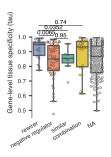

In [89]:
fig, ax = nice_boxplot(ref_expr, "dev_tau", "gene_cat", dn_pal, ["rewire", "DN", "similar", "combination", "NA"], 
            [1.01, 1.045, 1.08, 0.99], 0.35, "", ["rewirer", "negative regulator", "similar", "combination", "NA"], 
            "gene-level tissue specificity (tau)", False, (0.3, 1.23), 
            "developmental gene expression\nclassified TF genes", figsize=(1.3, 2))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels(["rewirer", "negative regulator", "similar", "combination", "NA"], rotation=30, 
                   ha="right", va="top")
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xlabel("")
ax.set_ylabel("Gene-level tissue specificity (tau)", position=(0, 0.38))

# manually set left axis so it stops at 1.0
ax.set_ylim((0.45, 1.2))
ax.spines['left'].set_visible(False)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0.45, 1],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())


ax.tick_params(axis='x', length=0)
fig.savefig("../../figures/fig7/DN_DevTau_Gene_Boxplot.pdf", dpi="figure", bbox_inches="tight")

0.03756217923447623
0.005594405594405594
0.5049759772618353
0.3779490357958727


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


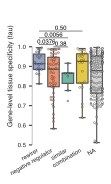

In [88]:
fig, ax = nice_boxplot(ref_expr, "gtex_ds_tau", "gene_cat", dn_pal, ["rewire", "DN", "similar", "combination", "NA"], 
            [1.01, 1.045, 1.08, 0.999], 0.35, "", ["rewirer", "negative regulator", "similar", "combination", "NA"], 
            "gene-level tissue specificity (tau)", False, (0.3, 1.23), 
            "GTEx gene expression\nclassified TF genes", figsize=(1.3, 2.5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels(["rewirer", "negative regulator", "similar", "combination", "NA"], rotation=30, 
                   ha="right", va="top")
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xlabel("")
ax.set_ylabel("Gene-level tissue specificity (tau)", position=(0, 0.38))

# manually set left axis so it stops at 1.0
ax.set_ylim((0.5, 1.2))
ax.spines['left'].set_visible(False)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0.5, 1],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())

ax.tick_params(axis='x', length=0)
fig.savefig("../../figures/fig7/DN_GTExDsTau_Gene_Boxplot.pdf", dpi="figure", bbox_inches="tight")

## 7. CREB1 vignette: expression

In [85]:
def developmental_tissue_expression_plot(gene_name, palette_name, figsize, ylim, means, cols, fig_suffix, shorten_x=False):
    n_isos = len(means.loc[genes_gtex == gene_name])
    palette = sns.color_palette(palette_name, as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[genes_gtex == gene_name, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[genes_gtex == gene_name, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    
    if shorten_x:
        xticks = list(axes[1].get_xticklabels())
        xticks_short = [x.get_text().split("-")[0].strip() for x in xticks]
        axes[1].set_xticklabels(xticks_short, rotation=90, va="top", ha="center")
        
    axes[0].set_ylabel('log2(TPM + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('Percentage of gene expression')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False)
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    axes[1].tick_params(axis='x', which='major', labelsize=PAPER_FONTSIZE-1.5)
    
    for spine in ['right', 'top']:
        axes[0].spines[spine].set_visible(False)
        axes[1].spines[spine].set_visible(False)
    
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/fig7/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


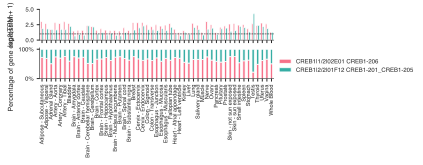

In [86]:
rename_for_viz = {"Adipose - Subcutaneous": "Adipose - Subcutaneous",
                  "Adipose - Visceral (Omentum)": "Adipose - Visceral",
                  "Adrenal Gland": "Adrenal Gland",
                  "Artery - Aorta": "Artery - Aorta",
                  "Artery - Coronary": "Artery - Coronary",
                  "Artery - Tibial": "Artery - Tibial",
                  "Bladder": "Bladder",
                  "Brain - Amygdala": "Brain - Amygdala",
                  "Brain - Anterior cingulate cortex (BA24)": "Brain - Anterior cortex",
                  "Brain - Caudate (basal ganglia)": "Brain - Caudate",
                  "Brain - Cerebellar Hemisphere": "Brain - Cerebellar hemisphere",
                  "Brain - Cerebellum": "Brain - Cerebellum",
                  "Brain - Cortex": "Brain - Cortex",
                  "Brain - Frontal Cortex (BA9)": "Brain - Frontal cortex",
                  "Brain - Hippocampus": "Brain - Hippocampus",
                  "Brain - Hypothalamus": "Brain - Hypothalamus",
                  "Brain - Nucleus accumbens (basal ganglia)": "Brain - Nucleus accumbens",
                  "Brain - Putamen (basal ganglia)": "Brain - Putamen",
                  "Brain - Spinal cord (cervical c-1)": "Brain - Spinal cord",
                  "Brain - Substantia nigra": "Brain - Substantia nigra",
                  "Breast - Mammary Tissue": "Breast",
                  "Cervix - Ectocervix": "Cervix - Ectocervix",
                  "Cervix - Endocervix": "Cervix - Endocervix",
                  "Colon - Sigmoid": "Colon - Sigmoid",
                  "Colon - Transverse": "Colon - Transverse",
                  "Esophagus - Gastroesophageal Junction": "Esophagus - Junction",
                  "Esophagus - Mucosa": "Esophagus - Mucosa",
                  "Esophagus - Muscularis": "Esophagus - Muscularis",
                  "Fallopian Tube": "Fallopian tube",
                  "Heart - Atrial Appendage": "Heart - Atrial appendage",
                  "Heart - Left Ventricle": "Heart - Left ventricle",
                  "Kidney - Cortex": "Kidney",
                  "Liver": "Liver",
                  "Lung": "Lung",
                  "Minor Salivary Gland": "Salivery gland",
                  "Muscle - Skeletal": "Muscle",
                  "Nerve - Tibial": "Nerve",
                  "Ovary": "Ovary",
                  "Pancreas": "Pancreas",
                  "Pituitary": "Pituitary",
                  "Prostate": "Prostate",
                  "Skin - Not Sun Exposed (Suprapubic)": "Skin - not sun exposed",
                  "Skin - Sun Exposed (Lower leg)": "Skin - sun exposed",
                  "Small Intestine - Terminal Ileum": "Small intestine",
                  "Spleen": "Spleen",
                  "Testis": "Testis",
                  "Uterus": "Uterus",
                  "Vagina": "Vagina",
                  "Whole Blood": "Whole Blood"}

means_gtex_renamed = means_gtex.rename(columns=rename_for_viz)
developmental_tissue_expression_plot("CREB1", "husl", (4.2, 1.25), (0, 5), means_gtex_renamed, 
                                     means_gtex_renamed.columns, 
                                     "means_gtex_all_renamed")

## 8. make supplemental tables

In [87]:
# supp table: DN classifications
supp_negregs = pairs[["gene_symbol", "Ensembl_gene_ID", "family", "ref_iso",
                      "alt_iso", "dbd_pct_lost", "m1h_cat", "y1h_cat", "y2h_cat", "loc_cat", "dn_cat", "dn_short"]]
supp_negregs.dn_short.value_counts()

dn_short
NA         272
DN         102
rewire      57
similar     15
likely       1
Name: count, dtype: int64

In [88]:
supp_negregs.columns = ["gene_symbol", "Ensembl_gene_ID", "family", "reference_isoform",
                        "alternative_isoform", "DBD_pct_lost_in_alt",
                        "M1H_activation_category", "PDI_category", "PPI_category", "localization_category",
                        "detailed_alt_iso_classification",
                        "alt_iso_classification"]
supp_negregs = supp_negregs[["gene_symbol", "Ensembl_gene_ID", "family", "reference_isoform",
                             "alternative_isoform", "DBD_pct_lost_in_alt",
                             "PDI_category", "PPI_category", "M1H_activation_category", "localization_category",
                             "alt_iso_classification", "detailed_alt_iso_classification"]]

supp_negregs["alt_iso_classification"].replace("DN", "negative regulator", inplace=True)
supp_negregs["detailed_alt_iso_classification"] = supp_negregs["detailed_alt_iso_classification"].str.replace("DN", "negative regulator")

supp_negregs["alt_iso_classification"].replace("rewire", "rewirer", inplace=True)
supp_negregs["detailed_alt_iso_classification"].replace("rewire", "rewirer", inplace=True)

supp_negregs["alt_iso_classification"].replace("similar", "similar to ref.", inplace=True)
supp_negregs["detailed_alt_iso_classification"].replace("similar", "similar to ref.", inplace=True)

supp_negregs["alt_iso_classification"].replace("likely", "likely non-functional", inplace=True)
supp_negregs["detailed_alt_iso_classification"].replace("likely", "likely non-functional", inplace=True)

supp_negregs[supp_negregs["alt_iso_classification"] == "negative regulator"].sample(5)

,gene_symbol,Ensembl_gene_ID,family,reference_isoform,alternative_isoform,DBD_pct_lost_in_alt,PDI_category,PPI_category,M1H_activation_category,localization_category,alt_iso_classification,detailed_alt_iso_classification
109,EBF1,ENSG00000164330,EBF1,EBF1-1,EBF1-3,53.503185,PDI loss,NA,rewire,no localization change,negative regulator,"negative regulator (PDIs,DBD loss)"
178,HEY1,ENSG00000164683,bHLH,HEY1-2,HEY1-1,0.000000,PDI loss,NA,similar,no localization change,negative regulator,negative regulator (PDIs)
241,NR4A1,ENSG00000123358,Nuclear receptor,NR4A1-3,NR4A1-1,0.000000,NA,no PPI change (all PPIs),activation loss,no localization change,negative regulator,negative regulator (activ)
239,MYF6,ENSG00000111046,bHLH,MYF6-2,MYF6-1,0.000000,PDI loss,NA,similar,NA,negative regulator,negative regulator (PDIs)
255,TBX5,ENSG00000089225,T-box,TBX5-1,TBX5-3,0.000000,PDI rewire,NA,activation loss,localization loss,negative regulator,"negative regulator (activ, loc loss)"


In [89]:
supp_negregs.alt_iso_classification.value_counts()

alt_iso_classification
NA                       272
negative regulator       102
rewirer                   57
similar to ref.           15
likely non-functional      1
Name: count, dtype: int64

In [90]:
supp_negregs.to_csv("../../supp/SuppTable_NegRegs.txt", sep="\t", index=False)

In [91]:
supp_negregs[supp_negregs['alt_iso_classification'] == 'rewirer'].sort_values(by='alternative_isoform')

,gene_symbol,Ensembl_gene_ID,family,reference_isoform,alternative_isoform,DBD_pct_lost_in_alt,PDI_category,PPI_category,M1H_activation_category,localization_category,alt_iso_classification,detailed_alt_iso_classification
295,ARNT2,ENSG00000172379,bHLH,ARNT2-1,ARNT2-2,0.000000,NA,PPI rewire,rewire,NA,rewirer,rewirer
47,ATF2,ENSG00000115966,bZIP,ATF2-1,ATF2-2,0.000000,NA,no PPI change (all PPIs),activation GoF,no localization change,rewirer,rewirer
259,DDIT3,ENSG00000175197,bZIP,DDIT3-2,DDIT3-1,0.000000,NA,PPI rewire,NA,no localization change,rewirer,rewirer
326,DLX4,ENSG00000108813,Homeodomain,DLX4-1,DLX4-2,0.000000,PDI rewire,NA,NA,no localization change,rewirer,rewirer
97,ELF2,ENSG00000109381,Ets,ELF2-2,ELF2-1,0.000000,NA,PPI rewire,rewire,NA,rewirer,rewirer
35,ESRRG,ENSG00000196482,Nuclear receptor,ESRRG-1,ESRRG-2,0.000000,NA,PPI rewire,rewire,NA,rewirer,rewirer
212,FLI1,ENSG00000151702,Ets,FLI1-1,FLI1-3,0.000000,no PDI change,NA,rewire,no localization change,rewirer,rewirer
149,FOXP2,ENSG00000128573,Forkhead,FOXP2-2,FOXP2-1,0.000000,NA,PPI rewire,similar,no localization change,rewirer,rewirer
150,FOXP2,ENSG00000128573,Forkhead,FOXP2-2,FOXP2-4,0.000000,NA,PPI rewire,rewire,no localization change,rewirer,rewirer
7,GRHL3,ENSG00000158055,Grainyhead,GRHL3-3,GRHL3-4,0.000000,NA,PPI rewire,similar,no localization change,rewirer,rewirer
